<h1 style="text-align:center;">Machine Translation</h1>
<h3 style="text-align:center;">Encoder-Decoder (Vanilla)</h3>

<br>

## Initial Deployment

---

In [1]:
# Import the libraries
import nltk, re, tqdm, keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

<br>

## Load Dataset

---

In [2]:
# Load the english dataset
with open("./dataset/en.txt", encoding='utf-8') as f:
    en = f.read().split("\n")

# Load the french dataset
with open("./dataset/fr.txt", encoding='utf-8') as f:
    fr = f.read().split("\n")

# Report
print("English: \n", en[:2])
print("\nFrench: \n", fr[:2])

English: 
 ['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']

French: 
 ["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']


<br>

## Text Processing & Feature Extraction

---

In [3]:
# Function for preprocessing the texts
def text_preprocessing(text):

    # Lowercase
    text = text.lower()

    # Remove unnecessary characters
    text = re.sub(r"[/.,|?><;:±!@#$%^&*()_+=-]", " ", text)

    # Remove extra empty spaces
    text = " ".join(text.split())

    return text

In [4]:
# Preprocess the texts
en = np.array([text_preprocessing(i) for i in tqdm.tqdm(en, ncols=100, colour="blue")])
fr = np.array([text_preprocessing(i) for i in tqdm.tqdm(fr, ncols=100, colour="blue")])

# Report
print("English: \n", en[:2])
print("\nFrench: \n", fr[:2])

100%|███████████████████████████████████████████████████| 137861/137861 [00:01<00:00, 128056.87it/s]

English: 
 ['new jersey is sometimes quiet during autumn and it is snowy in april'
 'the united states is usually chilly during july and it is usually freezing in november']

French: 
 ["new jersey est parfois calme pendant l' automne et il est neigeux en avril"
 'les états unis est généralement froid en juillet et il gèle habituellement en novembre']


In [5]:
# Function for creating Word2Int and Int2Word
def prepare_word_dictionay(list_of_texts, language):

    # Unique tokens
    text = " ".join(list_of_texts.ravel()).lower()                  # Convert list of strings into one string
    tokens = nltk.tokenize.word_tokenize(text, language=language)   # Tokenize
    unique_tokens = np.unique(tokens)                               # Unique tokens

    # Initialize Word2Int
    word2int = {}

    # Add necessary tags  
    word2int["<SOS>"] = 1        # Start-of-sequence <SOS> tag
    word2int["<EOS>"] = 2        # End-of-sequence <EOS> tag
    word2int["<UNK>"] = 3        # Unknown <UNK> tag

    # Loop over unique tokens
    for i_token in tqdm.tqdm(unique_tokens, ncols=100, colour="blue"):

        # Add to Word2Int
        word2int[i_token] = max(word2int.values())+1

    # Make Int2Word
    int2word = {idx: word for word, idx in word2int.items()}

    return word2int, int2word

In [6]:
# Create word2int and int2word
word2int_en, int2word_en = prepare_word_dictionay(list_of_texts=en, language="english")
word2int_fr, int2word_fr = prepare_word_dictionay(list_of_texts=fr, language="french")

100%|█████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 115035.76it/s]


In [7]:
# Label encoding function; For converting words to numerical values
def label_encoding(text, word2int, language):

    # Tokenize
    tokens = nltk.tokenize.word_tokenize(text, language=language)

    # Add staring/ending tag
    tokens.insert(0, "<SOS>")
    tokens.insert(len(tokens), "<EOS>")

    # Initialize a list
    encoded_tokens = []

    # Loop over tokens
    for i in tokens:

        # Append idx if it exist
        try: encoded_tokens.append(word2int[i])

        # Append <UNK> if it doesn't exist
        except: encoded_tokens.append(word2int["<UNK>"])

    return encoded_tokens


# Label decoding function; For converting numerical values to words
def label_decoding(tokens, int2word):

    # Initialize a list
    decoded_tokens = []

    # Loop over tokens
    for i in tokens:

        # Append word if it exist
        try: decoded_tokens.append(int2word[i])

        # Append <UNK> if it doesn't exist
        except: decoded_tokens.append("<UNK>")

    return decoded_tokens

In [8]:
# Label encode the texts
en_label_encoded = [label_encoding(i, language="english", word2int=word2int_en) for i in tqdm.tqdm(en, ncols=100, colour="blue", total=en.shape[0])]
fr_label_encoded = [label_encoding(i, language="french", word2int=word2int_fr) for i in tqdm.tqdm(fr, ncols=100, colour="blue", total=fr.shape[0])]

# Report
print("English: \n", en_label_encoded[:1])
print("\nFrench: \n", fr_label_encoded[:1])

100%|█████████████████████████████████████████████████████| 137861/137861 [00:25<00:00, 5303.82it/s]

English: 
 [[1, 123, 92, 89, 158, 141, 53, 16, 7, 90, 89, 157, 87, 12, 2]]

French: 
 [[1, 209, 154, 109, 229, 53, 232, 157, 4, 32, 110, 145, 109, 208, 101, 37, 2]]


In [9]:
# Function for padding the sequence
def padding(label_encoded_seq, max_len):

    # Pad the sequences
    padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences=label_encoded_seq, maxlen=max_len, 
                                                               padding="post", truncating="post")

    return padded_seq

In [10]:
# Maximum length for padding
max_len = max(max([len(i) for i in en_label_encoded]), max([len(i) for i in fr_label_encoded]))

# Pad the sequences
en_label_encoded = padding(en_label_encoded, max_len) 
fr_label_encoded = padding(fr_label_encoded, max_len) 

# Report
print("Shape of int tokens EN: ", en_label_encoded.shape)
print("Shape of int tokens FR: ", fr_label_encoded.shape)

Shape of int tokens EN:  (137861, 25)
Shape of int tokens FR:  (137861, 25)


In [11]:
# One-hot encoding; Function for converting numerical values to binary vectors
def one_hot_encoding(label_encoded_seq, length):

    # Initialize a list for one hot encoded
    one_hot_encoded = []
    
    # Loop over each token in the sequence
    for i_token in label_encoded_seq:

        # Initialize zero vector
        #token = np.zeros(shape=length)
        token = [0 for _ in range(length)]
        
        # Set one
        token[i_token] = 1

        # Append to the list
        one_hot_encoded.append(token)

    #return np.array(one_hot_encoded)
    return one_hot_encoded


# Function for one hot decoding
def one_hot_decoding(tokens):

    # Initialize a list for one hot decoded
    one_hot_decoded = []
        
    # Loop over each token in the sequence
    for i_token in tokens:

        # Append to the list
        one_hot_decoded.append(np.argmax(i_token))

    #return np.array(one_hot_decoded)
    return one_hot_decoded

In [12]:
# One-hot encoding
en_one_hot_encoded = np.array([one_hot_encoding(i, length=len(word2int_en)+1) for i in tqdm.tqdm(en_label_encoded, ncols=100, colour="blue")])
fr_one_hot_encoded = np.array([one_hot_encoding(i, length=len(word2int_fr)+1) for i in tqdm.tqdm(fr_label_encoded, ncols=100, colour="blue")])

# Report
print("Shape of int tokens EN: ", en_one_hot_encoded.shape)
print("Shape of int tokens FR: ", fr_one_hot_encoded.shape)

100%|█████████████████████████████████████████████████████| 137861/137861 [01:55<00:00, 1189.51it/s]


Shape of int tokens EN:  (137861, 25, 201)
Shape of int tokens FR:  (137861, 25, 349)


In [13]:
# Function for splitting the dataset into training/testing set
def split_train_test(x, y, train_ratio=0.95):

    # Find the dividing index
    #div_idx = int(x.shape[0]*train_ratio)
    div_idx = int(len(x)*train_ratio)

    # Training set
    x_train, y_train = x[:div_idx], y[:div_idx]

    # Testing set
    x_test, y_test = x[div_idx:], y[div_idx:]

    return x_train, y_train, x_test, y_test

In [14]:
# Split the dataset into training and testing set
x_train, y_train, x_test, y_test = split_train_test(x=en_one_hot_encoded, y=fr_one_hot_encoded, train_ratio=0.95)

# Report
print("x-train shape: ", x_train.shape) 
print("y-train Shape: ", y_train.shape)
print("x-test Shape:  ", x_test.shape)
print("y-test Shape:  ", y_test.shape)

x-train shape:  (130967, 25, 201)
y-train Shape:  (130967, 25, 349)
x-test Shape:   (6894, 25, 201)
y-test Shape:   (6894, 25, 349)


<br>

## Model Construction and Training

---

In [15]:
# Encoder data
encoder_data  = x_train
print(f"Encoder Input Data - {encoder_data.shape}: ")
print(encoder_data[0])

Encoder Input Data - (130967, 25, 201): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [16]:
# Decoder data
decoder_data  = y_train
print(f"\nDecoder Input Data - {decoder_data.shape}: ")
print(decoder_data[0])


Decoder Input Data - (130967, 25, 349): 
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [17]:
# Hyperparameters
embedding_dim = 256
units = 1024
num_encoder_tokens = x_train.shape[-1]    # 203 
num_decoder_tokens = y_train.shape[-1]    # 348 
n_repeat_vector = max_len
latent_dim = 512

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, None, 201)]  0           []                               
                                                                                                  
 encoder_LSTM (LSTM)            [(None, None, 512),  1462272     ['encoder_input[0][0]']          
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 decoder_LSTM (LSTM)            (None, None, 512)    2099200     ['encoder_LSTM[0][0]',           
                                                                  'encoder_LSTM[0][1]',       

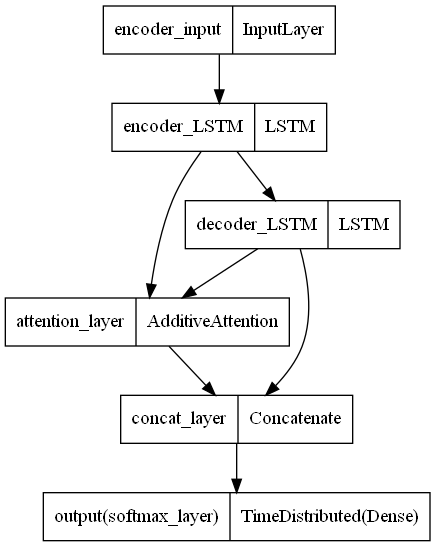

In [18]:
###########
# ENCODER #
###########

# Encoder input
encoder_inputs = keras.layers.Input(shape=(None, num_encoder_tokens), name="encoder_input")

# Squeeze a dimension
#encoder_inputs = tf.squeeze(encoder_inputs, axis=1, name="encoder_input_squeezed")

# Embedding layer (i.e. convert tokens into vectors) 
#encoder_embedding = tf.keras.layers.Embedding(num_encoder_tokens, embedding_dim)(encoder_inputs)

# LSTM layer
all_hidden_states_enc, state_h_enc, state_c_enc = keras.layers.LSTM(latent_dim, 
                                                                    return_sequences=True, 
                                                                    return_state=True, 
                                                                    name="encoder_LSTM")(encoder_inputs, initial_state=None)


###########
# DECODER #
###########

# Decoder - LSTM layer
all_hidden_states_decoder = tf.keras.layers.LSTM(units=latent_dim, 
                                                 return_sequences=True, 
                                                 return_state=False,
                                                 name="decoder_LSTM")(all_hidden_states_enc, initial_state=[state_h_enc, state_c_enc])


############################
# ADDITIVE ATTENTION LAYER #
############################

# Additive attention layer
# The input for AdditiveAttention: query, key. It returns a tensor of shape as query
attn_out, attn_states = keras.layers.AdditiveAttention(name='attention_layer')([all_hidden_states_enc, all_hidden_states_decoder], return_attention_scores=True)

# Concatenate attention input and decoder output
decoder_concat_input = keras.layers.Concatenate(axis=-1, name='concat_layer')([all_hidden_states_decoder, attn_out])


##########
# OUTPUT #
##########

# Dense layer
dense = keras.layers.Dense(num_decoder_tokens, activation='softmax', name='softmax_layer')

# Time-distributed layer
dense_time = keras.layers.TimeDistributed(dense, name='output')

# Feed data
out = dense_time(decoder_concat_input)


#########
# MODEL #
#########

# Define the model
model = keras.Model(inputs=encoder_inputs, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# Report
model.summary()
keras.utils.vis_utils.plot_model(model)

In [26]:
# Train the model
model.fit(encoder_data,
          decoder_data,
           epochs=10,
           batch_size=128,
           validation_split=0.2)

Epoch 1/10
410/410 [==============================] - 174s 418ms/step - loss: 1.3943 - accuracy: 0.6513 - val_loss: 0.8725 - val_accuracy: 0.7554
Epoch 2/10
410/410 [==============================] - 169s 411ms/step - loss: 0.6553 - accuracy: 0.8110 - val_loss: 0.4337 - val_accuracy: 0.8771
Epoch 3/10
410/410 [==============================] - 168s 411ms/step - loss: 0.3141 - accuracy: 0.9085 - val_loss: 0.2365 - val_accuracy: 0.9300
Epoch 4/10
410/410 [==============================] - 169s 412ms/step - loss: 0.1992 - accuracy: 0.9390 - val_loss: 0.1694 - val_accuracy: 0.9478
Epoch 5/10
410/410 [==============================] - 168s 411ms/step - loss: 0.1537 - accuracy: 0.9521 - val_loss: 0.1364 - val_accuracy: 0.9576
Epoch 6/10
410/410 [==============================] - 168s 409ms/step - loss: 0.1191 - accuracy: 0.9629 - val_loss: 0.1205 - val_accuracy: 0.9615
Epoch 7/10
410/410 [==============================] - 167s 409ms/step - loss: 0.1007 - accuracy: 0.9682 - val_loss: 0.1020 -

In [29]:
# Save the model
model.save("./saved models/model_3.h5")

In [30]:
# Load the model
model = tf.keras.models.load_model("./saved models/model_3.h5")
print("Model got loaded.")

Model got loaded.


<br>

## Inference

---

In [31]:
# Function for inference
def inference(model, text):

    # Label encode
    encoded = label_encoding(text, word2int_en, "english")

    # Padding
    encoded = padding([encoded], max_len)[0]

    # One hot encoding
    encoded = one_hot_encoding(encoded, length=len(word2int_en)+1)

    # Expand first dimension
    encoded = np.expand_dims(encoded, 0)

    # Predict
    prediction = model.predict(encoded)[0]

    # One-hot decoding
    decoded = one_hot_decoding(prediction)

    # Label decoding
    decoded = " ".join(label_decoding(decoded, int2word_fr))

    # Remove tags
    for i_token in ["<SOS>", "<EOS>", "<UNK>"]: decoded = decoded.replace(i_token, "").strip()

    return decoded

In [32]:
# Predict a sentence
input_text = "new jersey is sometimes quiet during autumn and it is snowy in april"
prediction = inference(model=model, text=input_text)
true_output = "new jersey est parfois calme pendant l' automne et il est neigeux en avril"

# Report
print("INPUT:       ", input_text)
print("PREDICTION:  ", prediction)
print("TRUE OUTPUT: ", true_output)

INPUT:        new jersey is sometimes quiet during autumn and it is snowy in april
PREDICTION:   new jersey est parfois calme pendant l ' automne et il est neigeux en avril
TRUE OUTPUT:  new jersey est parfois calme pendant l' automne et il est neigeux en avril


<br>

## Evaluation

---

#### THE END